# Simulação dos Trabalhos para Detecção de Malware com API Calls

Este notebook simula três abordagens distintas com base em artigos académicos recentes sobre deteção de malware com sequências de chamadas à API do Windows.

In [4]:
# --- Setup Comum (bibliotecas e dados simulados) ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, matthews_corrcoef

## Importar Dataset Comum aos Três Trabalhos
- Dataset: [Malware Analysis Datasets: API Call Sequences](https://ieee-dataport.org/open-access/malware-analysis-datasets-api-call-sequences)

C:\Users\pinto\AppData\Local\Temp\ipykernel_4704\577514115.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, ax=axes[0], legend=False, palette='Set2')
C:\Users\pinto\AppData\Local\Temp\ipykernel_4704\577514115.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=truncated_labels, y=top_10_calls.values, ax=axes[1], legend=False, palette='mako')


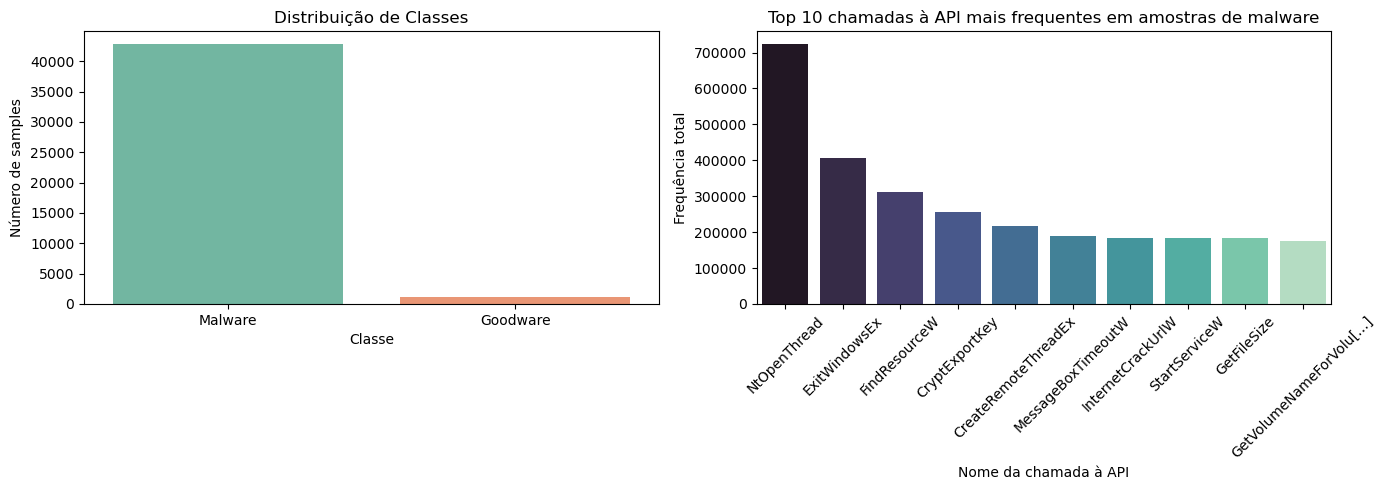

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar dataset
df = pd.read_csv("datasets/dynamic_api_call_sequence_per_malware_100_0_306.csv")

# Ver distribuição das classes (malware vs goodware)
class_distribution = df['malware'].value_counts().rename(index={0: 'Goodware', 1: 'Malware'})

# Contar frequência de cada chamada à API para amostras de malware
api_calls = df[df['malware'] == 1].drop(columns=['hash', 'malware'])
api_call_counts = api_calls.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)

# Nomes das APIs (mapeados manualmente)
names = ['NtOpenThread', 'ExitWindowsEx', 'FindResourceW', 'CryptExportKey', 'CreateRemoteThreadEx', 'MessageBoxTimeoutW', 'InternetCrackUrlW', 'StartServiceW', 'GetFileSize', 'GetVolumeNameForVolumeMountPointW', 'GetFileInformationByHandle', 'CryptAcquireContextW', 'RtlDecompressBuffer', 'SetWindowsHookExA', 'RegSetValueExW', 'LookupAccountSidW', 'SetUnhandledExceptionFilter', 'InternetConnectA', 'GetComputerNameW', 'RegEnumValueA', 'NtOpenFile', 'NtSaveKeyEx', 'HttpOpenRequestA', 'recv', 'GetFileSizeEx', 'LoadStringW', 'SetInformationJobObject', 'WSAConnect', 'CryptDecrypt', 'GetTimeZoneInformation', 'InternetOpenW', 'CoInitializeEx', 'CryptGenKey', 'GetAsyncKeyState', 'NtQueryInformationFile', 'GetSystemMetrics', 'NtDeleteValueKey', 'NtOpenKeyEx', 'sendto', 'IsDebuggerPresent', 'RegQueryInfoKeyW', 'NetShareEnum', 'InternetOpenUrlW', 'WSASocketA', 'CopyFileExW', 'connect', 'ShellExecuteExW', 'SearchPathW', 'GetUserNameA', 'InternetOpenUrlA', 'LdrUnloadDll', 'EnumServicesStatusW', 'EnumServicesStatusA', 'WSASend', 'CopyFileW', 'NtDeleteFile', 'CreateActCtxW', 'timeGetTime', 'MessageBoxTimeoutA', 'CreateServiceA', 'FindResourceExW', 'WSAAccept', 'InternetConnectW', 'HttpSendRequestA', 'GetVolumePathNameW', 'RegCloseKey', 'InternetGetConnectedStateExW', 'GetAdaptersInfo', 'shutdown', 'NtQueryMultipleValueKey', 'NtQueryKey', 'GetSystemWindowsDirectoryW', 'GlobalMemoryStatusEx', 'GetFileAttributesExW', 'OpenServiceW', 'getsockname', 'LoadStringA', 'UnhookWindowsHookEx', 'NtCreateUserProcess', 'Process32NextW', 'CreateThread', 'LoadResource', 'GetSystemTimeAsFileTime', 'SetStdHandle', 'CoCreateInstanceEx', 'GetSystemDirectoryA', 'NtCreateMutant', 'RegCreateKeyExW', 'IWbemServices_ExecQuery', 'NtDuplicateObject', 'Thread32First', 'OpenSCManagerW', 'CreateServiceW', 'GetFileType', 'MoveFileWithProgressW', 'NtDeviceIoControlFile', 'GetFileInformationByHandleEx', 'CopyFileA', 'NtLoadKey', 'GetNativeSystemInfo', 'NtOpenProcess', 'CryptUnprotectMemory', 'InternetWriteFile', 'ReadProcessMemory', 'gethostbyname', 'WSASendTo', 'NtOpenSection', 'listen', 'WSAStartup', 'socket', 'OleInitialize', 'FindResourceA', 'RegOpenKeyExA', 'RegEnumKeyExA', 'NtQueryDirectoryFile', 'CertOpenSystemStoreW', 'ControlService', 'LdrGetProcedureAddress', 'GlobalMemoryStatus', 'NtSetInformationFile', 'OutputDebugStringA', 'GetAdaptersAddresses', 'CoInitializeSecurity', 'RegQueryValueExA', 'NtQueryFullAttributesFile', 'DeviceIoControl', '__anomaly__', 'DeleteFileW', 'GetShortPathNameW', 'NtGetContextThread', 'GetKeyboardState', 'RemoveDirectoryA', 'InternetSetStatusCallback', 'NtResumeThread', 'SetFileInformationByHandle', 'NtCreateSection', 'NtQueueApcThread', 'accept', 'DecryptMessage', 'GetUserNameExW', 'SizeofResource', 'RegQueryValueExW', 'SetWindowsHookExW', 'HttpOpenRequestW', 'CreateDirectoryW', 'InternetOpenA', 'GetFileVersionInfoExW', 'FindWindowA', 'closesocket', 'RtlAddVectoredExceptionHandler', 'IWbemServices_ExecMethod', 'GetDiskFreeSpaceExW', 'TaskDialog', 'WriteConsoleW', 'CryptEncrypt', 'WSARecvFrom', 'NtOpenMutant', 'CoGetClassObject', 'NtQueryValueKey', 'NtDelayExecution', 'select', 'HttpQueryInfoA', 'GetVolumePathNamesForVolumeNameW', 'RegDeleteValueW', 'InternetCrackUrlA', 'OpenServiceA', 'InternetSetOptionA', 'CreateDirectoryExW', 'bind', 'NtShutdownSystem', 'DeleteUrlCacheEntryA', 'NtMapViewOfSection', 'LdrGetDllHandle', 'NtCreateKey', 'GetKeyState', 'CreateRemoteThread', 'NtEnumerateValueKey', 'SetFileAttributesW', 'NtUnmapViewOfSection', 'RegDeleteValueA', 'CreateJobObjectW', 'send', 'NtDeleteKey', 'SetEndOfFile', 'GetUserNameExA', 'GetComputerNameA', 'URLDownloadToFileW', 'NtFreeVirtualMemory', 'recvfrom', 'NtUnloadDriver', 'NtTerminateThread', 'CryptUnprotectData', 'NtCreateThreadEx', 'DeleteService', 'GetFileAttributesW', 'GetFileVersionInfoSizeExW', 'OpenSCManagerA', 'WriteProcessMemory', 'GetSystemInfo', 'SetFilePointer', 'Module32FirstW', 'ioctlsocket', 'RegEnumKeyW', 'RtlCompressBuffer', 'SendNotifyMessageW', 'GetAddrInfoW', 'CryptProtectData', 'Thread32Next', 'NtAllocateVirtualMemory', 'RegEnumKeyExW', 'RegSetValueExA', 'DrawTextExA', 'CreateToolhelp32Snapshot', 'FindWindowW', 'CoUninitialize', 'NtClose', 'WSARecv', 'CertOpenStore', 'InternetGetConnectedState', 'RtlAddVectoredContinueHandler', 'RegDeleteKeyW', 'SHGetSpecialFolderLocation', 'CreateProcessInternalW', 'NtCreateDirectoryObject', 'EnumWindows', 'DrawTextExW', 'RegEnumValueW', 'SendNotifyMessageA', 'NtProtectVirtualMemory', 'NetUserGetLocalGroups', 'GetUserNameW', 'WSASocketW', 'getaddrinfo', 'AssignProcessToJobObject', 'SetFileTime', 'WriteConsoleA', 'CryptDecodeObjectEx', 'EncryptMessage', 'system', 'NtSetContextThread', 'LdrLoadDll', 'InternetGetConnectedStateExA', 'RtlCreateUserThread', 'GetCursorPos', 'Module32NextW', 'RegCreateKeyExA', 'NtLoadDriver', 'NetUserGetInfo', 'SHGetFolderPathW', 'GetBestInterfaceEx', 'CertControlStore', 'StartServiceA', 'NtWriteFile', 'Process32FirstW', 'NtReadVirtualMemory', 'GetDiskFreeSpaceW', 'GetFileVersionInfoW', 'Findf_combined_combined_combinedirstFileExW', 'FindWindowExW', 'GetSystemWindowsDirectoryA', 'RegOpenKeyExW', 'CoCreateInstance', 'NtQuerySystemInformation', 'LookupPrivilegeValueW', 'NtReadFile', 'ReadCabinetState', 'GetForegroundWindow', 'InternetCloseHandle', 'FindWindowExA', 'ObtainUserAgentString', 'CryptCreateHash', 'GetTempPathW', 'CryptProtectMemory', 'NetGetJoinInformation', 'NtOpenKey', 'GetSystemDirectoryW', 'DnsQuery_A', 'RegQueryInfoKeyA', 'NtEnumerateKey', 'RegisterHotKey', 'RemoveDirectoryW', 'FindFirstFileExA', 'CertOpenSystemStoreA', 'NtTerminateProcess', 'NtSetValueKey', 'CryptAcquireContextA', 'SetErrorMode', 'UuidCreate', 'RtlRemoveVectoredExceptionHandler', 'RegDeleteKeyA', 'setsockopt', 'FindResourceExA', 'NtSuspendThread', 'GetFileVersionInfoSizeW', 'NtOpenDirectoryObject', 'InternetQueryOptionA', 'InternetReadFile', 'NtCreateFile', 'NtQueryAttributesFile', 'HttpSendRequestW', 'CryptHashMessage', 'CryptHashData', 'NtWriteVirtualMemory', 'SetFilePointerEx', 'CertCreateCertificateContext', 'DeleteUrlCacheEntryW', '__exception__']

map_API= {name: idx for idx, name in enumerate(names)}

api_call_counts.index = names[:len(api_call_counts)]


# Top 10 chamadas
top_10_calls = api_call_counts.head(10)

# Truncar os nomes longos para visualização
max_label_len = 20
truncated_labels = [name if len(name) <= max_label_len else name[:max_label_len] + "[…]" for name in top_10_calls.index]

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico da distribuição de classes
sns.barplot(x=class_distribution.index, y=class_distribution.values, ax=axes[0], legend=False, palette='Set2')
axes[0].set_title("Distribuição de Classes")
axes[0].set_ylabel("Número de samples")
axes[0].set_xlabel("Classe")

# Gráfico do top 10 chamadas em malware com nomes truncados
sns.barplot(x=truncated_labels, y=top_10_calls.values, ax=axes[1], legend=False, palette='mako')
axes[1].set_title("Top 10 chamadas à API mais frequentes em amostras de malware")
axes[1].set_ylabel("Frequência total")
axes[1].set_xlabel("Nome da chamada à API")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Trabalho 1 - Hammi et al. (2024)

- ✅ Vetorização binária com CountVectorizer(binary=True)
- ✅ Seleção de features com chi² (~30%)
- ✅ Divisão estratificada treino/teste
- ✅ VotingClassifier com 4 modelos simples (RF, NB, LR, KNN)
- ✅ Avaliação com Accuracy e MCC


In [3]:
sequences = df.drop(columns=['hash', 'malware']).astype(str).agg(' '.join, axis=1)

labels = df['malware']
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(sequences)

selector = SelectKBest(chi2, k=int(X.shape[1] * 0.3))
X_sel = selector.fit_transform(X, labels)

X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)

clf1 = RandomForestClassifier()
clf2 = MultinomialNB()
clf3 = LogisticRegression(max_iter=1000)
clf4 = KNeighborsClassifier()

from sklearn.metrics import classification_report

# Altere apenas isto para hard voting
voting = VotingClassifier(estimators=[
    ('rf', clf1), ('nb', clf2), ('lr', clf3), ('knn', clf4)
], voting='hard')

# Fit & Predict
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

# Avaliação
print(f"[Hammi et al.] ACC: {accuracy_score(y_test, y_pred):.3f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, digits=3))


[Hammi et al.] ACC: 0.984
MCC: 0.599
              precision    recall  f1-score   support

           0      0.765     0.481     0.591       324
           1      0.987     0.996     0.992     12839

    accuracy                          0.984     13163
   macro avg      0.876     0.739     0.791     13163
weighted avg      0.982     0.984     0.982     13163



## Trabalho 2 - Daeef et al. (2023)
| Elemento                             | Presente no Código                       | Comentário                                 |
| ------------------------------------ | ---------------------------------------- | ------------------------------------------ |
| **Vetorização por frequência**       | `CountVectorizer()`                      | ✅ Corresponde exatamente                   |
| **Modelos utilizados**               | RF, SVM, KNN                             | ✅ São os mesmos modelos testados no artigo |
| **Redução de features**              | `SelectKBest(chi2, k=30%)`               | ✅ Simula bem a redução de dimensionalidade |
| **Split estratificado treino/teste** | `train_test_split(..., stratify=labels)` | ✅ Correto                                  |
| **Avaliação com ACC e MCC**          | `accuracy_score`, `matthews_corrcoef`    | ✅ Usado no artigo                          |


In [4]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sequences)

selector = SelectKBest(chi2, k=int(X.shape[1] * 0.3))
X_sel = selector.fit_transform(X, labels)

X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)

for name, model in {
    'RF': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"[Daeef et al. | {name}] ACC: {accuracy_score(y_test, y_pred):.3f} | MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))


[Daeef et al. | RF] ACC: 0.989 | MCC: 0.730
              precision    recall  f1-score   support

           0      0.939     0.574     0.713       324
           1      0.989     0.999     0.994     12839

    accuracy                          0.989     13163
   macro avg      0.964     0.787     0.853     13163
weighted avg      0.988     0.989     0.987     13163

[Daeef et al. | SVM] ACC: 0.977 | MCC: 0.213
              precision    recall  f1-score   support

           0      1.000     0.046     0.088       324
           1      0.976     1.000     0.988     12839

    accuracy                          0.977     13163
   macro avg      0.988     0.523     0.538     13163
weighted avg      0.977     0.977     0.966     13163

[Daeef et al. | KNN] ACC: 0.985 | MCC: 0.649
              precision    recall  f1-score   support

           0      0.814     0.528     0.640       324
           1      0.988     0.997     0.993     12839

    accuracy                          0.985     

## Trabalho 3 - Prachi et al. (2023) - MalAnalyser

| Elemento do artigo                   | Presente no teu código?   | Comentário                           |
| ------------------------------------ | ------------------------- | ------------------------------------ |
| Vetorização com representação TF-IDF | ✅ `TfidfVectorizer()`     | Correto                              |
| Seleção de features (\~30%)          | ✅ `SelectKBest(chi2)`     | Aceitável como aproximação ao GLBPSO |
| Voting ensemble com RF, LR, SVM      | ✅ `VotingClassifier(...)` | Alinha bem com o artigo              |


In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sequences)

selector = SelectKBest(chi2, k=int(X.shape[1] * 0.3))
X_sel = selector.fit_transform(X, labels)

X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
svm = SVC(probability=True)

voting = VotingClassifier(estimators=[
    ('rf', rf), ('lr', lr), ('svm', svm)
], voting='soft')

voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print(f"[MalAnalyser] ACC: {accuracy_score(y_test, y_pred):.3f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, digits=3))

[MalAnalyser] ACC: 0.984
MCC: 0.578
              precision    recall  f1-score   support

           0      0.958     0.355     0.518       324
           1      0.984     1.000     0.992     12839

    accuracy                          0.984     13163
   macro avg      0.971     0.677     0.755     13163
weighted avg      0.983     0.984     0.980     13163



## Adicionar o dataset criado ( ultimo dataset analisado + )

C:\Users\pinto\AppData\Local\Temp\ipykernel_9520\659322774.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, ax=axes[0], palette='Set2')
C:\Users\pinto\AppData\Local\Temp\ipykernel_9520\659322774.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=truncated_labels, y=top_10_calls.values, ax=axes[1], palette='mako')


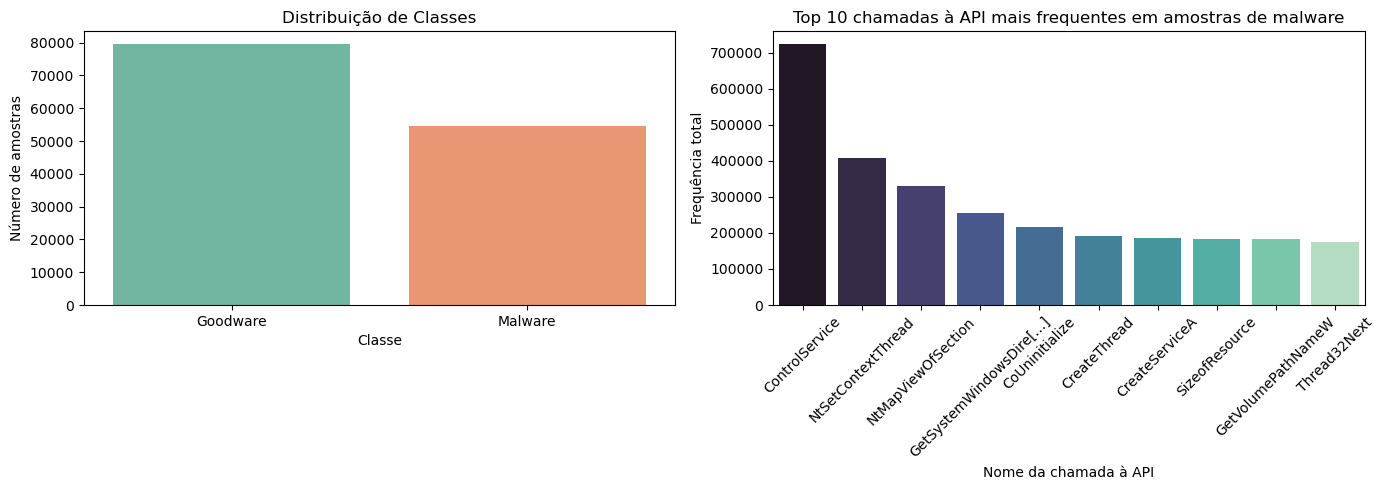

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load dataset
df = pd.read_csv("datasets/all_data_combined.csv")

# Load API mapping from JSON
with open("datasets/api_map.json") as f:
    api_map = json.load(f)

# Invert map: ID → API name
id_to_api = {v: k for k, v in api_map.items()}

# Class distribution
class_distribution = df['malware'].value_counts().rename(index={0: 'Goodware', 1: 'Malware'})

# Filter for malware only and remove non-API columns
api_calls = df[df['malware'] == 1].drop(columns=['hash', 'malware'])

# Count frequency of each API call ID
api_call_counts = api_calls.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)

# Top 10 most frequent API call IDs
top_10_calls = api_call_counts.head(10)

# Map API call IDs to names using JSON
top_10_names = [id_to_api.get(int(i), f"API_{i}") for i in top_10_calls.index]

# Truncate labels
max_label_len = 20
truncated_labels = [name if len(name) <= max_label_len else name[:max_label_len] + "[…]" for name in top_10_names]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
sns.barplot(x=class_distribution.index, y=class_distribution.values, ax=axes[0], palette='Set2')
axes[0].set_title("Distribuição de Classes")
axes[0].set_ylabel("Número de amostras")
axes[0].set_xlabel("Classe")

# Top 10 API calls
sns.barplot(x=truncated_labels, y=top_10_calls.values, ax=axes[1], palette='mako')
axes[1].set_title("Top 10 chamadas à API mais frequentes em amostras de malware")
axes[1].set_ylabel("Frequência total")
axes[1].set_xlabel("Nome da chamada à API")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Trabalho 1 - Hammi et al. (2024)

- ✅ Vetorização binária com CountVectorizer(binary=True)
- ✅ Seleção de features com chi² (~30%)
- ✅ Divisão estratificada treino/teste
- ✅ VotingClassifier com 4 modelos simples (RF, NB, LR, KNN)
- ✅ Avaliação com Accuracy e MCC


In [6]:
sequences = df.drop(columns=['hash', 'malware']).astype(str).agg(' '.join, axis=1)

labels = df['malware']
vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(sequences)

selector = SelectKBest(chi2, k=int(X.shape[1] * 0.3))
X_sel = selector.fit_transform(X, labels)

X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)

clf1 = RandomForestClassifier()
clf2 = MultinomialNB()
clf3 = LogisticRegression(max_iter=1000)
clf4 = KNeighborsClassifier()

from sklearn.metrics import classification_report

# Altere apenas isto para hard voting
voting = VotingClassifier(estimators=[
    ('rf', clf1), ('nb', clf2), ('lr', clf3), ('knn', clf4)
], voting='hard')

# Fit & Predict
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

# Avaliação
print(f"[Hammi et al.] ACC: {accuracy_score(y_test, y_pred):.3f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, digits=3))

import joblib
joblib.dump(voting, "models/modelo_trabalho1.pkl")
joblib.dump(vectorizer, "models/vectorizer_trabalho1.pkl")
joblib.dump(selector, "models/selector_trabalho1.pkl")



[Hammi et al.] ACC: 0.911
MCC: 0.821
              precision    recall  f1-score   support

           0      0.874     0.992     0.929     23845
           1      0.986     0.793     0.879     16422

    accuracy                          0.911     40267
   macro avg      0.930     0.892     0.904     40267
weighted avg      0.920     0.911     0.909     40267



['models/selector_trabalho1.pkl']

## Trabalho 2 - Daeef et al. (2023)
| Elemento                             | Presente no Código                       | Comentário                                 |
| ------------------------------------ | ---------------------------------------- | ------------------------------------------ |
| **Vetorização por frequência**       | `CountVectorizer()`                      | ✅ Corresponde exatamente                   |
| **Modelos utilizados**               | RF, SVM, KNN                             | ✅ São os mesmos modelos testados no artigo |
| **Redução de features**              | `SelectKBest(chi2, k=30%)`               | ✅ Simula bem a redução de dimensionalidade |
| **Split estratificado treino/teste** | `train_test_split(..., stratify=labels)` | ✅ Correto                                  |
| **Avaliação com ACC e MCC**          | `accuracy_score`, `matthews_corrcoef`    | ✅ Usado no artigo                          |


In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sequences)

selector = SelectKBest(chi2, k=int(X.shape[1] * 0.3))
X_sel = selector.fit_transform(X, labels)

X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)

for name, model in {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'RF': RandomForestClassifier(),

}.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"[Daeef et al. | {name}] ACC: {accuracy_score(y_test, y_pred):.3f} | MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

import joblib
joblib.dump(model, "models/modelo_trabalho2.pkl")
joblib.dump(vectorizer, "models/vectorizer_trabalho2.pkl")
joblib.dump(selector, "models/selector_trabalho2.pkl")

[Daeef et al. | SVM] ACC: 0.918 | MCC: 0.832
              precision    recall  f1-score   support

           0      0.894     0.978     0.934     23845
           1      0.962     0.832     0.892     16422

    accuracy                          0.918     40267
   macro avg      0.928     0.905     0.913     40267
weighted avg      0.922     0.918     0.917     40267

[Daeef et al. | KNN] ACC: 0.936 | MCC: 0.868
              precision    recall  f1-score   support

           0      0.933     0.961     0.947     23845
           1      0.941     0.900     0.920     16422

    accuracy                          0.936     40267
   macro avg      0.937     0.931     0.934     40267
weighted avg      0.937     0.936     0.936     40267

[Daeef et al. | RF] ACC: 0.944 | MCC: 0.885
              precision    recall  f1-score   support

           0      0.933     0.976     0.954     23845
           1      0.962     0.899     0.930     16422

    accuracy                          0.944     

['models/selector_trabalho2.pkl']

## Trabalho 3 - Prachi et al. (2023) - MalAnalyser

| Elemento do artigo                   | Presente no teu código?   | Comentário                           |
| ------------------------------------ | ------------------------- | ------------------------------------ |
| Vetorização com representação TF-IDF | ✅ `TfidfVectorizer()`     | Correto                              |
| Seleção de features (\~30%)          | ✅ `SelectKBest(chi2)`     | Aceitável como aproximação ao GLBPSO |
| Voting ensemble com RF, LR, SVM      | ✅ `VotingClassifier(...)` | Alinha bem com o artigo              |


In [9]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sequences)

selector = SelectKBest(chi2, k=int(X.shape[1] * 0.3))
X_sel = selector.fit_transform(X, labels)

X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)

rf = RandomForestClassifier()
lr = LogisticRegression(max_iter=1000)
svm = SVC(probability=True)

voting = VotingClassifier(estimators=[
    ('rf', rf), ('lr', lr), ('svm', svm)
], voting='soft')

voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print(f"[MalAnalyser] ACC: {accuracy_score(y_test, y_pred):.3f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred, digits=3))

import joblib
joblib.dump(model, "models/modelo_trabalho3.pkl")
joblib.dump(vectorizer, "models/vectorizer_trabalho3.pkl")
joblib.dump(selector, "models/selector_trabalho3.pkl")

[MalAnalyser] ACC: 0.931
MCC: 0.859
              precision    recall  f1-score   support

           0      0.910     0.981     0.944     23845
           1      0.968     0.860     0.911     16422

    accuracy                          0.931     40267
   macro avg      0.939     0.920     0.928     40267
weighted avg      0.934     0.931     0.931     40267



['models/selector_trabalho3.pkl']